# Experiment 6: The model is trained on 5 of the 6 subjects then evaluated on the 6th. This is done for each subject.

*   0 degree aspect angle
*   All actions
*   The letter (A, B, C or D) signifies the person whose data is used for the test samples
*   64-128 model




## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif os.getcwd() == 'C:\\Users\\macka\\Google Drive\\Level-4-Project\\notebooks\\reproducing_original_experiments':
    BASE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/"
    
else:
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"

DATA_PATH = BASE_PATH + 'data/'
MODEL_PATH = BASE_PATH + 'models/original_experiments/experiment_6/'
FIGURE_PATH = BASE_PATH + 'reports/figures/original_experiments/experiment_6/'
REPORT_PATH = BASE_PATH + 'reports/original_experiments/experiment_6/'  

from src.models.original_models import cnn_64_128
from src.data import load_data
from src.visualization import multiple_plots

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report,confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
# data_folders = ['noninitialised_A', 'noninitialised_B', 'noninitialised_C', 'noninitialised_D']

In [0]:
load_models = False

batch_size = 100
nb_classes = 7
nb_epoch = 150
# nb_epoch = 1
nb_train_samples = 34720
# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB

target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']

data_folders = {"noninitialised_A": {}, "noninitialised_B": {}, "noninitialised_C": {}, "noninitialised_D": {}}
for name, data_folder in data_folders.items():
    if load_models:
        data_folder["model"] = load_model(MODEL_PATH + name + '.h5')
    else:
        data_folder["model"] = cnn_64_128.make_model(img_rows, img_cols, nb_classes)

## Training and Evaluating Models

In [7]:
for name, data_folder in data_folders.items():
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = load_data.load_data((DATA_PATH + name), nb_train_samples)

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    if not load_models:    
        # train the model using SGD + momentum.
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        data_folder["model"].compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255

        history = data_folder["model"].fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=(X_test, Y_test),
            shuffle=True,
            verbose=1)
        data_folder["history"] = history


    y_pred = data_folder["model"].predict_classes(X_test)
    data_folder["classification_report"] = classification_report(
        np.argmax(Y_test,axis=1),
        y_pred,
        target_names=target_names)
    data_folder["confusion_matrix"] = confusion_matrix(
        np.argmax(Y_test,axis=1), y_pred)

Train on 34720 samples, validate on 6944 samples
Epoch 1/1
34720/34720 [==============================] - 75s 2ms/step - loss: 0.5679 - acc: 0.7791 - val_loss: 0.0222 - val_acc: 0.9974
Train on 34720 samples, validate on 6944 samples
Epoch 1/1
34720/34720 [==============================] - 71s 2ms/step - loss: 0.4496 - acc: 0.8260 - val_loss: 1.8661 - val_acc: 0.7105
Train on 34720 samples, validate on 6944 samples
Epoch 1/1
34720/34720 [==============================] - 71s 2ms/step - loss: 0.5122 - acc: 0.7983 - val_loss: 0.1686 - val_acc: 0.9427
Train on 34720 samples, validate on 6944 samples
Epoch 1/1
34720/34720 [==============================] - 71s 2ms/step - loss: 0.6073 - acc: 0.7677 - val_loss: 0.3329 - val_acc: 0.8871


## Analysis and Saving of Results

In [0]:
save_graph = True
save_model = True
save_report = True

### Plot and Save graph

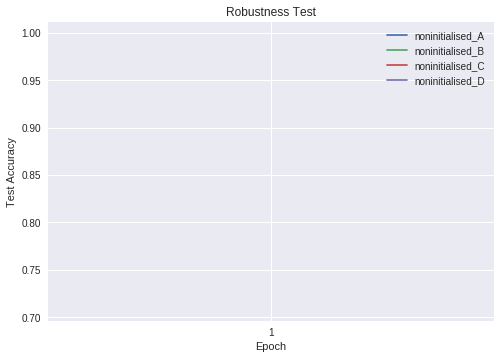

In [9]:
if not load_models:
    multiple_plots.plot_multiple_val_acc(
        data_folders,
        "Robustness Test",
        save=save_graph,
        path=FIGURE_PATH + "comparison.svg")

### Save Models

In [0]:
if not load_models and save_model:
    for name, data_folder in data_folders.items():
        data_folder['model'].save(MODEL_PATH + name + '.h5')

### Save Classification Report and Confusion Matricies

In [0]:
if save_report:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    for name, data_folder in data_folders.items():
        file.write("--------------------------------------------------\n") 
        file.write("Data Name: " + name + "\n") 
        file.write("Classification Report:\n") 
        file.write(data_folder['classification_report'])
        file.write("Confusion Matrix:\n") 
        file.write(np.array2string(data_folder['confusion_matrix']) + "\n")

    file.close() 